In [1]:
import hdbscan, umap, json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer


/Users/faustogerman/miniforge3/envs/PekinSearch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RAW_DATA = pd.read_json("./test_data_with_sentiment.json")
data = list(RAW_DATA["clean_text"])

## Generate word embeddings from corpus

In [3]:
model = SentenceTransformer('sentence-transformers/paraphrase-albert-small-v2')
embeddings = model.encode(data, show_progress_bar=True)

Batches: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


## Lower the dimensionality of word embeddings

In [4]:
umap_model_full = umap.UMAP(
    n_neighbors=3,
    n_components=5,
    metric='cosine',
    random_state=42
).fit(embeddings)

umap_embeddings = umap_model_full.transform(embeddings)

## Cluster the embeddings

In [5]:
cluster = hdbscan.HDBSCAN(
    min_cluster_size=3,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
).fit(umap_embeddings)

In [6]:
# Return a cluster label for each of the documents
# A label of -1 means that the document is an outlier
cluster.labels_

array([ 7,  5,  1,  1,  7,  7,  7,  6,  7,  7,  2,  3,  6,  1,  7,  6,  3,
        7,  7,  4,  5,  7,  4,  5,  7,  7,  7,  7,  1,  7,  1,  7,  7,  1,
        3,  7,  6,  7,  0,  0,  7,  0,  0,  0,  7,  2,  4,  7,  2,  1,  7,
        6,  7,  3,  6,  7,  7,  7,  7,  7,  5,  2,  5,  2,  6, -1, -1,  2,
       -1, -1, -1,  3,  5,  2,  4,  3,  2,  1,  3,  2,  3,  2,  2,  4, -1,
        7,  7,  1,  7,  1,  7,  6,  6,  2,  7,  7,  3,  5,  6,  6])

In [7]:
np.unique(cluster.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

## Visualize the clusters in 2-dimensions

This is only for visualization purposes. The model and clusters used for the rest of the experiment are defined above.


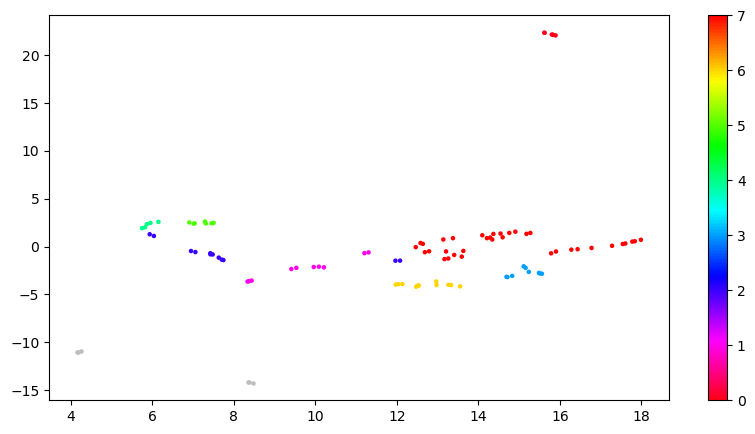

In [8]:
# Prepare data
umap_model_2d = umap.UMAP(
    n_neighbors=3,
    n_components=2,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)
result = pd.DataFrame(umap_model_2d, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='hsv_r')
plt.colorbar()

## Group the Documents into Their Clusters


In [9]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index=False).agg({'Doc': ' '.join})

In [10]:
docs_per_topic

,Topic,Doc
0,-1,Chinese authorities call on retired soldiers t...
1,0,Toyota unveils all electric SUV concept under ...
2,1,The controversy of MLS and Apple my opinion vi...
3,2,Summer International uses social media data to...
4,3,Always getting the information from the inside...
5,4,I ve had Other issues happen to but the most c...
6,5,COP27 PolicyPod Is the world climate disaster ...
7,6,Wireless Charger 3 in 1 Wireless Charging Stat...
8,7,NowPlaying University of Texas at Austin Earth...


## Create Class-Based TF-IDF Matrix (c-TF-IDF)

The difference between regular TF-IDF and Class-Based TF-IDF is that with c-TF-IDF we join the documents in each class (cluster) and teat the cluster as one big document.


In [11]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(
        ngram_range=ngram_range,
        stop_words="english"
    ).fit(documents)
    
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [12]:
tf_idf.shape  # (number of words, number of clusters)

(750, 9)

## Extract the Relevant Words in Each Cluster


In [13]:
# Get the most important words in each of the clusters
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j])
                           for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words


# How many documents are in each cluster
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes


top_n_words = extract_top_n_words_per_topic(
    tf_idf, count, docs_per_topic, n=10)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)


/Users/faustogerman/miniforge3/envs/PekinSearch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
8,7,35
3,2,12
7,6,11
2,1,10
4,3,9
6,5,7
0,-1,6
1,0,5
5,4,5


## Show the Words in Each Cluster

In [14]:
for cluster_id in np.unique(cluster.labels_):
    print(f"Words in Cluster #{cluster_id}")
    print("====================================")

    for word, score in sorted(top_n_words[cluster_id], key=lambda x: x[1], reverse=True):
        print(word, ' ' * (20 - len(word)), score)
    
    print("\n")

Words in Cluster #-1
foxconn               0.16106087492225757
retired               0.11311477088128974
fifa22                0.11311477088128974
trending              0.11311477088128974
callofduty            0.11311477088128974
tiktok                0.11311477088128974
leagueoflegends       0.11311477088128974
telegram              0.11311477088128974
zoom                  0.11311477088128974
fortnite              0.11311477088128974


Words in Cluster #0
zero                  0.2538756164028806
electric              0.2538756164028806
toyota                0.2538756164028806
badge                 0.2538756164028806
concept               0.2538756164028806
suv                   0.2538756164028806
unveils               0.2384246370135624
read                  0.22536102007904896
goog                  0.21822886948258988
news                  0.2140448003651064


Words in Cluster #1
spirited              0.08971110751924855
ryan                  0.08971110751924855
way                

## Append Clusters to Dataset

In [15]:
RAW_DATA['cluster_id'] = cluster.labels_
RAW_DATA['cluster_x'] = result['x']
RAW_DATA['cluster_y'] = result['y']

RAW_DATA

,id,text,clean_text,created_at,is_sensitive,retweet_count,reply_count,like_count,quote_count,hashtags,sentiment_label,sentiment_score,emotion_label,emotion_score,cluster_id,cluster_x,cluster_y
0,1593098408189120514,RT @groundzerofm: #NowPlaying: University of T...,NowPlaying University of Texas at Austin Earth...,2022-11-17 04:27:13,False,1,0,0,0,"[NowPlaying, Alexa, Android, Apple]",Neutral,0.921415,joy,0.911417,7,14.209333,0.877520
1,1593098273359007745,RT @orfonline: 🚨 #COP27 PolicyPod: Is the worl...,COP27 PolicyPod Is the world climate disaster ...,2022-11-17 04:26:41,False,25,0,0,0,"[COP27, climate]",Neutral,0.737647,joy,0.875336,5,7.291540,2.613396
2,1593098232405831681,"The controversy of #MLS and #Apple +, my opini...",The controversy of MLS and Apple my opinion via,2022-11-17 04:26:31,False,0,0,0,0,"[MLS, Apple]",Neutral,0.874647,anger,0.990544,1,10.209354,-2.163689
3,1593098049509031936,"Pixel7pro is big mistake?\nNot solved, indian ...",Pixel7pro is big mistake Not solved indian cus...,2022-11-17 04:25:47,False,0,0,0,0,"[teampixel, sunderpichai, googlepixel7pro, goo...",Negative,0.853460,joy,0.908345,1,11.204018,-0.685552
4,1593097989958291456,RT @Tian_A1: BrainKids Educative Game Now avai...,BrainKids Educative Game Now available Apple A...,2022-11-17 04:25:33,False,3,0,0,0,"[Apple, Google]",Neutral,0.697752,joy,0.932771,7,14.340724,0.735864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1593088146547380225,#Apple (@Apple) Watch : #SteveWozniak (@stevew...,Apple Watch SteveWozniak est un fan,2022-11-17 03:46:26,False,0,0,0,0,"[Apple, SteveWozniak]",Neutral,0.747318,joy,0.613935,7,14.594671,0.967804
96,1593087913214238721,That’s how #Apple so wealthy. https://t.co/zlK...,That s how Apple so wealthy,2022-11-17 03:45:31,False,0,0,1,0,[Apple],Neutral,0.566213,joy,0.993431,3,14.830197,-3.055272
97,1593087783010082816,. @Apple rolls out #iPhone emergency SOS satel...,rolls out iPhone emergency SOS satellite alert...,2022-11-17 03:45:00,False,0,0,1,0,"[iPhone, Mobile, Technology]",Neutral,0.848590,joy,0.559165,5,6.908204,2.518192
98,1593087425072746497,RT @TechInRL: How to Find your Apple Watch! (U...,How to Find your Apple Watch Updated applewatc...,2022-11-17 03:43:34,False,2,0,0,0,"[applewatchseries7, AppleWatch, AppleWatchSeri...",Neutral,0.533736,joy,0.940285,6,12.538852,-4.064796


## Save as a New Dataset

In [16]:
RAW_DATA.to_json("test_data_with_sentiment_and_clusters.json", orient='records')

## Save New JSON File with Topic Clusters
This is an example of the data sent to the front-end by the NLP Engine

In [17]:
# convert dates to strings
RAW_DATA['created_at'] = RAW_DATA['created_at'].astype(str)

# Combine the DataFrame and the topic clusters into one JSON file.
json_data = {
    "tweets": RAW_DATA.to_dict(orient="records"),
    "topics": top_n_words,
}

# Writing to sample.json
with open("sample_api_response.json", "w") as outfile:
    outfile.write(json.dumps(json_data))